In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
import re

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [3]:
fake=pd.read_csv('https://raw.githubusercontent.com/laxmimerit/fake-real-news-dataset/main/data/Fake.csv')

In [4]:
real=pd.read_csv('https://raw.githubusercontent.com/laxmimerit/fake-real-news-dataset/main/data/True.csv')

In [5]:
fake.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [6]:
fake['subject'].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

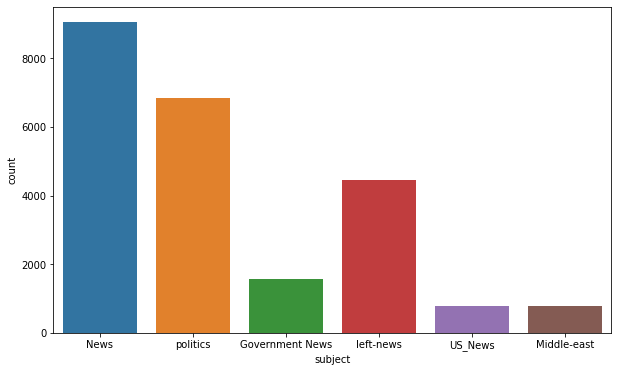

In [7]:
plt.figure(figsize=(10,6))
sns.countplot(x='subject',data=fake)

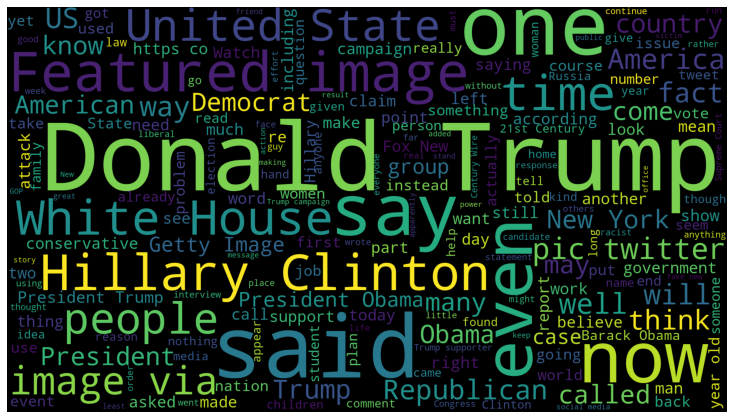

In [8]:
text=' '.join(fake['text'].tolist())
wordcloud=WordCloud(width=1920, height=1080).generate(text)
gif=plt.figure(figsize=(10,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [9]:
text=' '.join(real['text'].tolist())

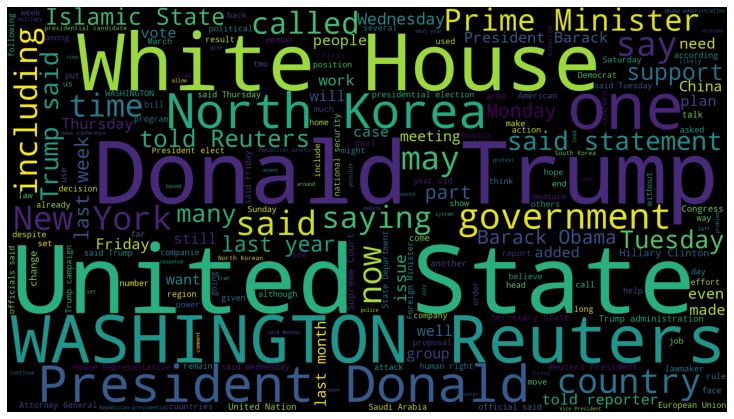

In [10]:
wordcloud=WordCloud(width=1920, height=1080).generate(text)
gif=plt.figure(figsize=(10,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [11]:
unknown_publishers=[]
for index,row in enumerate(real.text.values):
  try:
    record=row.split('-',maxsplit=1)
    record[1]
    assert(len(record[0])<120)
  except:
    unknown_publishers.append(index)

In [12]:
len(unknown_publishers)

222

In [13]:
real.iloc[unknown_publishers].text

7        The following statements were posted to the ve...
8        The following statements were posted to the ve...
12       The following statements were posted to the ve...
13       The following statements were posted to the ve...
14        (In Dec. 25 story, in second paragraph, corre...
                               ...                        
20135     (Story corrects to million from billion in pa...
20500     (This Sept 8 story corrects headline, clarifi...
20667     (Story refiles to add dropped word  not , in ...
21246     (Story corrects third paragraph to show Mosul...
21339     (Story corrects to fix spelling in paragraph ...
Name: text, Length: 222, dtype: object

In [14]:
real.iloc[8970]

title      Graphic: Supreme Court roundup
text                                     
subject                      politicsNews
date                       June 16, 2016 
Name: 8970, dtype: object

In [15]:
real.drop(8970,axis=0)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"


In [16]:
publisher=[]
tmp_text=[]
for index,row in enumerate(real.text.values):
  if index in unknown_publishers:
    tmp_text.append(row)
    publisher.append('Unknown')
    
  else:
    record=row.split('-',maxsplit=1)
    publisher.append(record[0].strip())
    tmp_text.append(record[1].strip())

In [17]:
real['pulisher']=publisher
real['text']=tmp_text

In [18]:
real.head()

,title,text,subject,date,pulisher
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)


In [19]:
real.shape

(21417, 5)

In [20]:
empty_fake_index=[index for index,text in enumerate(fake.text.tolist()) if str(text).strip()==""]

In [21]:
real['text']=real['title']+" "+real['text']
fake['text']=fake['title']+" "+fake['text'] 

In [22]:
real['text']=real['text'].apply(lambda x:str(x).lower())
fake['text']=fake['text'].apply(lambda x:str(x).lower())

In [23]:
real['class']=1
fake['class']=0

In [24]:
real= real[['text','class']]
fake=fake[['text','class']]

In [25]:
data=real.append(fake,ignore_index=True)

In [26]:
data.sample(5)

,text,class
40891,more jobs! dow company ceo at mi trump rally: ...,0
36647,watch female hispanic cop’s “all lives matter”...,0
4112,trump pressures democrats on obamacare to get ...,1
33741,unhinged liberal uses the ‘n-word’ on live tv ...,0
30437,the funniest and most obscene local news fail...,0


In [27]:
!pip install spacy==2.2.3
!python -m spacy download en_core_web_sm
!pip install beautifulsoup4==4.9.1
!pip install textblob==0.15.3
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

     |████████████████████████████████| 10.4 MB 4.9 MB/s 
     |████████████████████████████████| 2.2 MB 32.9 MB/s 
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: spacy
    Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4
     |████████████████████████████████| 12.0 MB 5.4 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
     |████████████████████████████████| 115 kB 5.5 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-lm68yh7h
  Running command git clone -q https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip

In [28]:
import preprocess_kgptalkie as ps

In [29]:
data['text']=data['text'].apply(lambda x:ps.remove_special_chars(x))

In [30]:
import gensim

In [31]:
y=data['class'].values

In [32]:
X=[d.split() for d in data['text'].tolist()]

In [ ]:
DIM=100
w2v_model=gensim.models.Word2Vec(sentences=X ,size=DIM,window=5,min_count=1)

In [ ]:
len(w2v_model.wv.vocab)

In [ ]:
w2v_model.wv['india']

In [ ]:
w2v_model.wv.most_similar('modi')

In [ ]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(X)

In [ ]:
X = tokenizer.texts_to_sequences(X)

In [ ]:
tokenizer.word_index

In [ ]:
plt.hist([len(x) for x in X], bins=700)
plt.show()

In [ ]:
nos=np.array([len(x) for x in X])
len(nos[nos>1000])

In [ ]:
maxlen=1000
X=pad_sequences(X, maxlen=maxlen)

In [ ]:
len(X[0])

In [ ]:
vocab_size=len(tokenizer.word_index)+1
vocab=tokenizer.word_index

In [ ]:
def get_weight_matrix(model):
  weight_matrix=np.zeros((vocab_size,DIM))
  for word, i in vocab.items():
    weight_matrix[i]=model.wv[word]
  return weight_matrix

In [ ]:
embedding_vectors=get_weight_matrix(w2v_model)

In [ ]:
embedding_vectors.shape

In [ ]:
model=Sequential()
model.add(Embedding(vocab_size,output_dim=DIM, weights=[embedding_vectors],input_length=maxlen,trainable=False))
model.add(LSTM(units=128))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])

In [ ]:
model.summary()

In [ ]:
X_train, X_test,y_train,y_test=train_test_split(X,y)

In [ ]:
model.fit(X_train,y_train,validation_split=0.3,epochs=6)

In [ ]:
y_pred=(model.predict(X_test)>=0.5).astype(int)

In [ ]:
accuracy_score(y_test,y_pred)

In [ ]:
print(classification_report(y_test,y_pred))

In [ ]:
x=['this is a news']

In [ ]:
x=tokenizer.texts_to_sequences(x)
x=pad_sequences(x,maxlen=maxlen)

In [ ]:
model.predict(x)

In [ ]:
(model.predict(X)>=0.5).astype(int)